# Kaggle Competition House Prices
By: Rohinesh Ram

# 0. Imports / Functions

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the Data

- two data sets from Kaggle, testset and trainset
- also txt of feature descriptions

In [151]:
# Train data set
df_train = pd.read_csv('data_folder/train.csv')
# Test data set
df_test = pd.read_csv('data_folder/test.csv')
# Data description
f = open("data_folder/data_description.txt", "r")

# Display each
print(f.read())
print(df_train.head())
print(df_test.head())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

## 2. Inspect and Preprocess

## 2.1 Missing Data

In [139]:
nan_cols = df_train.columns[df_train.isna().any()]
print("Columns with nan:", nan_cols)

Columns with nan: Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


In [142]:
df_train.isnull().sum().sort_values(ascending=False).head(10)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
dtype: int64

Some of the columns with categorical data are labelled 'NA' which pandas interprets as NaN, these data could be missing OR should be 'NA'. It can be assumed that NaN values for categorical features are supposed to be 'NA' except because it can be seen that majority of PoolQC, MiscFeature, Alley, etc. data points are missing. The exception is 'Electrical' features which likely just missing data as there is no category for 'NA'.

**Numerical**
- LotFrontage
- MasVnrArea
- GarageYrBlt(NaN if no garage)

**Categorical**
- Alley (NA if no alley)
- MasVnrType (None if no masonry)
- BsmtQual (NA if no basement)
- BsmtCond (NA if no basement)
- BsmtExposure (NA if no basement)
- BsmtFinType1 (NA if no basement)
- BsmtFinType2 (NA if no basement)
- Electrical (probably has missing data)
- FireplaceQu (NA if no fireplace)
- GarageType (NA if no garage)
- GarageFinish (NA if no garage)
- GarageQual (NA if no garage)
- GarageCond (NA if no garage)
- PoolQC (NA if no Pool)
- Fence (NA if no fence)
- MiscFeature (NA if no miscekkabeiys features)

First, rows missing data for numerical features will be removed. Rows with Electrical features missing will be removed. Finally, the columns with categorical data that have NaN will be converted to 'NA'

In [156]:
# remove missing data
df_train = df_train[df_train['LotFrontage'].notna()]
df_train = df_train[df_train['MasVnrArea'].notna()]
df_train = df_train[df_train['GarageYrBlt'].notna()]
df_train = df_train[df_train['Electrical'].notna()]

print("Shape after removing missing data:", df_train.shape)

Shape after removing missing data: (1120, 81)


In [160]:
# replace categorical features
df_train = df_train.fillna('NA')
df_train.shape

(1120, 81)

## 2.2 Inspect Data

Distribute of the sales price.

Text(0.5, 1.0, 'Distribution of Sales Price')

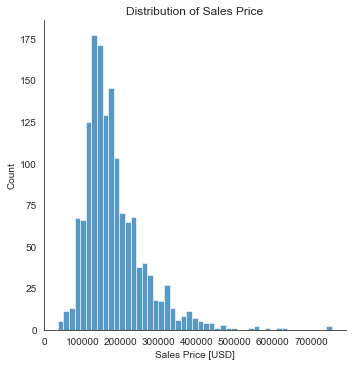

In [143]:
sns.set_style("white")
ax = sns.displot(df_train['SalePrice'])
ax.set_xlabels("Sales Price [USD]")
plt.title("Distribution of Sales Price")

In [145]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

- Majority of houses sold within the 100K - 300K range
- outliers in the +700K Range

## 2.1 Pre-process

We have a mix of numerical, categorical features, and ordinal features, lets find which are which:

In [78]:
numerical = 'LotFrontage, LotArea, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold'
categorical = 'MSSubClass, MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, Foundation, Heating, CentralAir, Electrical, Functional, GarageType, GarageFinish, PavedDrive, MiscFeature, SaleType, SaleCondition'
ordinal = 'OverallQual, OverallCond, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, KitchenQual, FireplaceQu, GarageQual, GarageCond, PoolQC, Fence'

numerical = numerical.split(', ')
categorical = categorical.split(', ')
ordinal = ordinal.split(', ')

**Numerical**: LotFrontage, LotArea, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, Bedroom, Kitchen, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold 

**Categorical**: MSSubClass, MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, Foundation, Heating, CentralAir, Electrical, Functional, GarageType, GarageFinish, PavedDrive, MiscFeature, SaleType, SaleCondition

Features related to quality or condition were considered ordinal because they imply some sort of rank or order, i.e. good quality is better than fair quality.

**Ordinal**: OverallQual, OverallCond, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, KitchenQual, FireplaceQu, GarageQual, GarageCond, PoolQC, Fence

Convert categorical, and ordinal to numerical using OneHotEncoder and OrdinalEncoder

In [59]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

ct = ColumnTransformer(
    [('onehot', OneHotEncoder(sparse = False), categorical),
    ('ordinal', OrdinalEncoder(), ordinal),
    ('nothing', 'passthrough', numerical)])

ct.fit(X_train)
X_train_trans = ct.transform(X_train)
print("Shape of Feature Matrix after encoding:",X_train_trans.shape)

Shape of Feature Matrix after encoding: (1460, 258)


## 3 Prepare Feature matrix and Target Vector

In [79]:
y_train = df_train['SalePrice']
X_train = df_train.loc[:,'MSSubClass':'SaleCondition'] # do not need ID
X_test = df_test.loc[:,'MSSubClass':'SaleCondition'] # do not need ID
id = df_train['Id']

print("X train shape:", X_train.shape)
print("y train shape:", y_train.shape)
print("X test shape:", X_test.shape)
X_test.columns

X train shape: (1460, 79)
y train shape: (1460,)
X test shape: (1459, 79)


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo